In [ ]:
ENV["JULIA_CUDA_MEMORY_POOL"] = "none"

using StaticArrays, StructArrays, Random, Distributions, CUDA, Printf, BenchmarkTools, Plots, ProgressBars, LinearAlgebra, CSV, Tables

mutable struct Particle
    x::SVector{3,Float64}
    v::SVector{3,Float64}
    a::SVector{3,Float64}
end

function extract(p,d)
    return reshape(reinterpret(Float64,p),3,:)[d,:]
end;

function evolve!(particles,N,dt,steps,acceleration::Function)
    k = (blockIdx().x-1)*blockDim().x + threadIdx().x
    if(k<=N)
        for i in 1:steps
            particles.a[k]=acceleration(particles.x[k],particles.v[k],i*dt)
            particles.v[k]+=particles.a[k]*dt
            particles.x[k]+=particles.v[k]*dt
        end
    end
    return
end

pi=3.141592657;
c = 2.99792458E8; #Speed of light
kB = 1.38064852E-23;
amu = 1.6604E-27;
m = 59 * amu;
g=9.8;

In [ ]:
#Examples of potential
function gravity(x::SVector{3,Float64},v::SVector{3,Float64},t)
    acceleration=SVector(0,-9.4,0)
    return acceleration
end

function free_space(x::SVector{3,Float64},v::SVector{3,Float64},t)
    acceleration=SVector(0,0,0)
    return acceleration
end

macro gen_harmonic_trap_f(name,freq)
    quote
    function $(esc(name))(x::SVector{3,Float64},v::SVector{3,Float64},t)
        acceleration=-(($freq*2*$(esc(pi))).^2).*x;
        return acceleration
    end
    end
end

macro gen_harmonic_trap_k(name,k)
    quote
    function $(esc(name))(x::SVector{3,Float64},v::SVector{3,Float64},t)
        acceleration=-$k.*x
        return acceleration
    end
    end
end

macro gen_time_dependent_harmonic_trap_f(name,freq)
    quote
    function $(esc(name))(x::SVector{3,Float64},v::SVector{3,Float64},t)
        lattice_a=500;
        x0=0.5*lattice_a*(t^2);
        acceleration=-(($freq*2*$(esc(pi))).^2).*(x-x0);
        return acceleration
    end
    end
end

#@gen_harmonic_trap(trap,SVector(1000,1000,1000)) 
#@gen_harmonic_trap_k(trap_k,SVector(1,1,1)) 
#trap(SVector(1.0,10.,0))
#@macroexpand@gen_harmonic_trap(trap,SVector(1000,1000,1000)) 
#@macroexpand@gen_harmonic_trap_k(trap_k,SVector(1,1,1)) 

In [ ]:
function waist(z,w0,zR,z0)
    w0 * sqrt(1 + ((z-z0) / zR)^2);
end

macro gen_astigamatism_gaussian_trap(name)
    quote
    function$(esc(name))(x::SVector{3,Float64},v::SVector{3,Float64},t)
        xx=x[1];
        yy=x[2];
        zz=x[3];
            
        waist_x = waist(zz, $w0x, $zRx, $z0x);
        waist_y = waist(zz, $w0y, $zRy, $z0y);
            
        Vxyz=-$V * $w0x * $w0y / waist_x / waist_y * exp(-2 * ((xx / waist_x)^2+ (yy / waist_y)^2));
        Vxyz=Vxyz/$m;
    
        z2 = zz^2;
        x_factor = 1 / (z2 - 2 * zz * $z0x + $z0x^2 + $zRx^2);
        y_factor = 1 / (z2 - 2 * zz * $z0y + $z0y^2 + $zRy^2);

        Fx=4 * Vxyz * xx / ($w0x^2 * (1 + ((zz - $z0x) / $zRx)^2));
        Fy=4 * Vxyz * yy / ($w0y^2 * (1 + ((zz - $z0y) / $zRy)^2)) - $g;
        Fz= - Vxyz * (4 * (xx^2) * (zz - $z0x) * ($zRx^2) * (x_factor^2) / ($w0x^2) + 4 * (yy^2) * (zz - $z0y) * ($zRy^2) * (y_factor^2) / ($w0y^2) - (zz - $z0x) * x_factor - (zz - $z0y) * y_factor);
        
            acceleration=SVector(Fx,Fy,Fz);
        return acceleration
        end
    end
end




In [202]:
lambda = 1064e-9; #ODT wavelength

w0 = 50e-6; #ODT waist
Pmeasured = 22; #ODT power measured before objective
astigmatism = 0e-6; #astigmatism
anisotropy = 1.00; #Ratio between waist on x axis and waist on y axis
Pactual = Pmeasured;

omegaXA = 2 * pi * (495.45950E12 - 0.5 * 10.3041447E9 + 0.5 * 17.9231E9); #CaF X-A transition frequency
omegaXB = 2 * pi * (564.81469E12 - 0.5 * 10.3041447E9 + 0.5 * 17.1608E9); #CaF X-B transition frequency
GammaA = 1 / (19.2E-9); #CaF X-A linewidth
GammaB = 1 / (25.1E-9); #CaF X-B linewidth
f00A = 0.9643; #CaF X v=0 -> A v=0 Franck-Condon factor
f00B = 0.999; #CaF X v=0 -> B v=0 Franck-Condon factor

w0x = w0 / anisotropy;
w0y = w0 * anisotropy;
zRx = pi * (w0x^2) / lambda;
zRy = pi * (w0y^2) / lambda;
z0x = astigmatism;
z0y = -astigmatism;
PtoICoeff = 2 * sqrt(1 + (z0x / zRx)^2) * sqrt(1 + (z0y / zRy)^2) * sqrt((zRx * zRy / w0x / w0y)^2 / (z0x^2 + zRx^2) / (z0y^2 + zRy^2)) / pi;
@printf("PtoICoeff = %e\n",PtoICoeff)
@printf("PtoICoeff = %e\n",2/pi/w0^2)
omegalambda = 2 * pi * c / lambda;
@printf("omegalambda = %e\n", omegalambda);
UAcoeff = 3 * pi / 2 * (c / omegaXA)^2 / omegaXA * (GammaA / (omegaXA - omegalambda) + GammaA / (omegaXA + omegalambda)) * f00A * 2 / 3;
UBcoeff = 3 * pi / 2 * (c / omegaXB)^2 / omegaXB * (GammaB / (omegaXB - omegalambda) + GammaB / (omegaXB + omegalambda)) * f00B * 1 / 3;
Ucoeff = (UAcoeff + UBcoeff) * 0.931364;
@printf("Ucoeff = %e\n", Ucoeff);
V = PtoICoeff * Pactual * Ucoeff;
@printf("V = %e\n", V/kB);

zRx2 = zRx^2;
zRy2 = zRy^2;
astigmatism2 = astigmatism^2;
factor_1 = astigmatism * (zRx2 - zRy2);
factor_2 = zRx2 + zRy2 - 2 * astigmatism2;
factor_sqrt = sqrt(864 * (factor_2^3) + (108 * factor_1)^2);
numerator = (6.0^(2.0 / 3.0)) * factor_2 - (6.0^(1.0 / 3.0)) * ((9 * factor_1 + factor_sqrt / 12)^(2.0 / 3.0));
denominator = 6 * (9 * factor_1 + factor_sqrt / 12)^(1.0 / 3.0);
z0 = numerator / denominator;
@printf("factor_1=%e\nfactor_2=%e\nfactor_sqrt=%e\n",factor_1,factor_2,factor_sqrt)
@printf("z0 %e/%e= %e\n",numerator,denominator, z0);

num1 = -12 * (astigmatism^2) + 6 * (zRx^2) + 6 * (zRy^2);
num2 = 108 * astigmatism * (zRx^2) - 108 * astigmatism * (zRy^2);
@printf("num1=%e\nnum2=%e\n",num1,num2);
zcenter =  num1 / ( 3 * (2.0^(2.0 / 3.0)) * (num2 + sqrt(4 * (num1^3) +  (num2^2)))^(1.0 / 3.0) )-(num2 + sqrt(4 * num1^3 + num2^2)^(1.0 / 3.0)) / (6 * (2.0^(1.0 / 3.0)))
@printf("zcenter = %e\n", zcenter);
waistfactorx = sqrt(1 + ((zcenter - astigmatism) / zRx)^ 2);
waistfactory = sqrt(1 + ((zcenter - astigmatism) / zRy)^ 2);
omega_x = 2 * sqrt((V / m) / ((w0x^2) * waistfactory * (waistfactorx^3) ));
omega_y = 2 * sqrt((V / m) / ((w0y^2) * waistfactorx * (waistfactory^3) ));
omega_r = sqrt(omega_x * omega_y);
omega_z = sqrt(-(V / m) * (2 * (zcenter - astigmatism) * (zcenter + astigmatism) / ((waistfactorx * waistfactory)^3 * (zRx * zRy)^2)+ (3 * (zcenter + astigmatism)^2/((zRy^4) * (waistfactory^5)) - 1 / ((waistfactory^3) * (zRy^2)) / waistfactorx+ (3 * (zcenter - astigmatism)^2) / ((zRx^4) * (waistfactorx^5)) - 1 / ((waistfactorx^3) * (zRx^2) )) / waistfactory));
Vmax = 1.0E6 * V / (kB * waistfactorx * waistfactory); #in uK
@printf("omega_x = %e\n", omega_x);
@printf("omega_y = %e\n", omega_y);
@printf("omega_z = %e\n", omega_z);
@printf("Vmax = %e uK\n", Vmax);

function trap_depth(x::SVector{3,Float64})
    wz=waist(x[3],w0,zRx,z0)
    return V*(w0/wz)^2*exp(-2(x[1]^2+x[2]^2)/wz^2)
end

@gen_astigamatism_gaussian_trap(static_trap)
trap_depth(SVector(0.0,0.0,0.03))/kB*1E6

PtoICoeff = 2.546479e+08
PtoICoeff = 2.546479e+08
omegalambda = 1.770349e+15
Ucoeff = 5.035192e-37
V = 2.043129e-04
factor_1=0.000000e+00
factor_2=1.089749e-04
factor_sqrt=3.343849e-05
z0 -1.626303e-19/8.443186e-02= -1.926172e-18
num1=6.538494e-04
num2=0.000000e+00
zcenter = -1.734723e-18
omega_x = 6.787613e+03
omega_y = 6.787613e+03
omega_z = 3.251051e+01
Vmax = 2.043129e+02 uK


11.663315432880266

In [173]:
@code_lowered static_trap(SVector(0.0,0.0,0.0),SVector(0.0,0.0,0.0),SVector(0.0,0.0,0.0))

CodeInfo(
1 ─        xx = Base.getindex(x, 1)
│          yy = Base.getindex(x, 2)
│          zz = Base.getindex(x, 3)
│          waist_x = Main.waist(zz, 5.0e-5, 0.007381561694078946, 0.0)
│          waist_y = Main.waist(zz, 5.0e-5, 0.007381561694078946, -0.0)
│   %6   = -2.8208426997635502e-27
│   %7   = %6 * 5.0e-5 * 5.0e-5
│   %8   = %7 / waist_x
│   %9   = %8 / waist_y
│   %10  = xx / waist_x
│   %11  = Core.apply_type(Base.Val, 2)
│   %12  = (%11)()
│   %13  = Base.literal_pow(Main.:^, %10, %12)
│   %14  = yy / waist_y
│   %15  = Core.apply_type(Base.Val, 2)
│   %16  = (%15)()
│   %17  = Base.literal_pow(Main.:^, %14, %16)
│   %18  = %13 + %17
│   %19  = -2 * %18
│   %20  = Main.exp(%19)
│          Vxyz = %9 * %20
│          Vxyz = Vxyz / 9.79636e-26
│   %23  = zz
│   %24  = Core.apply_type(Base.Val, 2)
│   %25  = (%24)()
│          z2 = Base.literal_pow(Main.:^, %23, %25)
│   %27  = z2
│   %28  = 2 * zz * 0.0
│   %29  = %27 - %28
│   %30  = Core.apply_type(Base.Val, 2)
│   %31  =

In [ ]:
function evolve_snapshot!(particles,N,dt,steps,acceleration::Function,trajectory,snapshots)
    k = (blockIdx().x-1)*blockDim().x + threadIdx().x
    interval=floor(steps/snapshots)
    snapshot_i=1
    if(k<=N)
        for i in 1:steps
            particles.a[k]=acceleration(particles.x[k],particles.v[k],i*dt)
            particles.v[k]+=particles.a[k]*dt
            particles.x[k]+=particles.v[k]*dt
            if mod(i,interval)==0
                trajectory[snapshot_i,k]=particles[k];
                snapshot_i=snapshot_i+1
            end
        end
    end
    return
end

In [ ]:
function evolve_linear_ramp_snapshot!(particles,N,dt,steps,acceleration::Function,trajectory,snapshots,start,stop)
    k = (blockIdx().x-1)*blockDim().x + threadIdx().x
    interval=floor(steps/snapshots)
    snapshot_i=1
    scale_step=(stop-start)/steps
    if(k<=N)
        for i in 1:steps
            particles.a[k]=acceleration(particles.x[k],particles.v[k],i*dt)*(start+scale_step*i)
            particles.v[k]+=particles.a[k]*dt
            particles.x[k]+=particles.v[k]*dt
            if mod(i,interval)==0
                trajectory[snapshot_i,k]=particles[k];
                snapshot_i=snapshot_i+1
            end
        end
    end
    return
end

initial_width_x = 5.530853e-06
initial_width_y = 5.530853e-06
initial_width_z = 1.154743e-03
Effective GPU memory usage: 10.00% (1.100 GiB/11.000 GiB)
CUDA allocator usage: 0 bytes
Memory pool usage: 0 bytes (0 bytes allocated, 0 bytes cached)
cublocks=79Threads=128 Blocks=79
Effective GPU memory usage: 100.00% (11.000 GiB/11.000 GiB)
CUDA allocator usage: 6.706 GiB
Memory pool usage: 6.706 GiB (6.706 GiB allocated, 0 bytes cached)
Effective GPU memory usage: 100.00% (11.000 GiB/11.000 GiB)
CUDA allocator usage: 6.707 GiB
Memory pool usage: 6.707 GiB (6.707 GiB allocated, 0 bytes cached)
Effective GPU memory usage: 100.00% (11.000 GiB/11.000 GiB)
CUDA allocator usage: 6.707 GiB
Memory pool usage: 6.707 GiB (6.707 GiB allocated, 0 bytes cached)
Effective GPU memory usage: 100.00% (11.000 GiB/11.000 GiB)
CUDA allocator usage: 6.707 GiB
Memory pool usage: 6.707 GiB (6.707 GiB allocated, 0 bytes cached)
Effective GPU memory usage: 100.00% (11.000 GiB/11.000 GiB)
CUDA allocator usage: 6.707

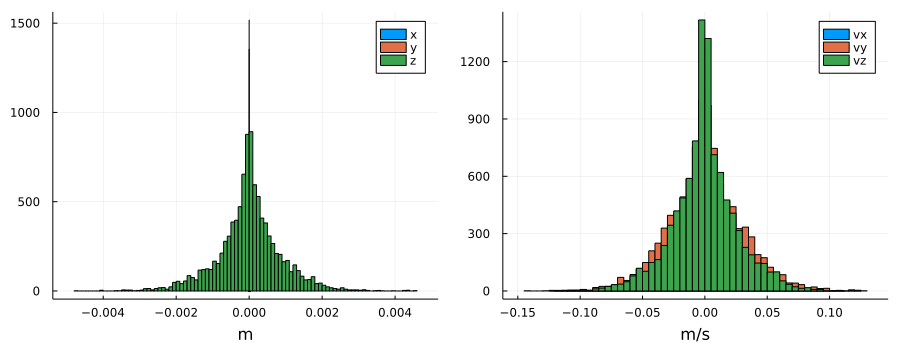

In [229]:
T=10e-6;
initial_width_x = sqrt(kB * T / (omega_x^2 * m));
initial_width_y = sqrt(kB * T / (omega_y^2 * m));
initial_width_z = sqrt(kB * T / (omega_z^2 * m));
@printf("initial_width_x = %e\n", initial_width_x);
@printf("initial_width_y = %e\n", initial_width_y);
@printf("initial_width_z = %e\n", initial_width_z);
mean_v = sqrt(kB * T / m);
total_energy = 0.0;
mean_energy = 0.0;
mean_temperature=10;

device_reset!()
cuparticles=nothing
cutrajectory=nothing
cuparticles_backup=nothing
GC.gc(true)
CUDA.reclaim()
CUDA.memory_status()

#Initialize
N=10000
steps=1000;
dt=1e-6;


trajectory_length=10000;
trajectory_interval=steps/trajectory_length*dt;
trajectory=StructArray{Particle,1}(undef,(trajectory_length,N))
cutrajectory=replace_storage(CuArray,trajectory);


particles=StructArray{Particle,1}(undef,N)
x0=[0 0 0]
sx=[initial_width_x initial_width_y initial_width_z].*0.0001
v0=[0 0 0]
sv=[mean_v mean_v mean_v]
for k in 1:N
particles.x[k]=SVector(rand(Normal(x0[1],sx[1])),rand(Normal(x0[2],sx[2])),rand(Normal(x0[3],sx[3])))
particles.v[k]=SVector(rand(Normal(v0[1],sv[1])),rand(Normal(v0[2],sv[2])),rand(Normal(v0[3],sv[3])))
particles.a[k]=SVector(0,0,0)
end
rounds=1;

rand_one=rand(1:N*rounds,N);

cuthreads=128
cublocks=floor(Int,(N+cuthreads-1)/cuthreads)
@printf("cublocks=%d",cublocks)
#cublocks=64
@printf "Threads=%d Blocks=%d\n" cuthreads cublocks
cuparticles=replace_storage(CuArray,particles)
CUDA.memory_status()
cuparticles_backup=similar(cuparticles)
CUDA.memory_status()
copyto!(cuparticles_backup,cuparticles)
p=StructArray{Particle,1}(undef,N*rounds)
CUDA.memory_status()

function generate_particles!(acceleration,steps,dt,N,rounds,p)
    
    for k in 1:rounds
    CUDA.@sync begin
        @cuda threads=cuthreads blocks=cublocks evolve!(cuparticles,N,dt,steps,acceleration)
    end   
        copyto!(p,1+(k-1)*N,cuparticles,1,N)
    end
end

seed_particles=StructArray{Particle,1}(undef,N)

CUDA.memory_status()
CUDA.@sync begin
    @cuda threads=cuthreads blocks=cublocks evolve!(cuparticles,N,dt,5000000,static_trap)
end   
 CUDA.memory_status()
generate_particles!(static_trap,10000,dt,N,rounds,p)
for k in 1:N
    seed_particles[k]=p[rand_one[k]];
end
CUDA.memory_status()

#Copy from device to host
p=seed_particles
#Plot current distribution
gr(size=(900,350),layout=(1,2),bottom_margin=5Plots.mm)
histogram(extract(p.x,1),subplot=1,label="x",xaxis="m")
histogram!(extract(p.x,2),subplot=1,label="y")
histogram!(extract(p.x,3),subplot=1,label="z")
histogram!(extract(p.v,1),subplot=2,label="vx",xaxis="m/s")
histogram!(extract(p.v,2),subplot=2,label="vy")
histogram!(extract(p.v,3),subplot=2,label="vz")

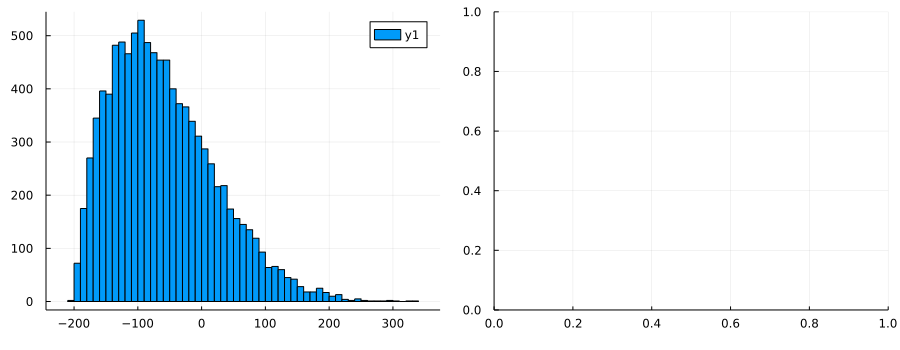

In [224]:
p=particles
p=seed_particles
TotalEnergy=(-broadcast(trap_depth,p.x).+broadcast(norm,p.v)*m*0.5)/kB*1E6
#TotalEnergy=(-broadcast(trap_depth,p.x).+(extract(p.v,1).^2+extract(p.v,2).^2)*m*0.5)/kB*1E6
histogram(TotalEnergy)
#sum(TotalEnergy.<0)/N

In [120]:
#jump potential and back, save trajectory
dt=1E-6
#jump_to=0.01
trajectory_interval=1E-5
scan_list=[0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0];
result_list=similar(scan_list)
save_trajectory=false

for (index,jump_to) in enumerate(scan_list)
    @time begin
        copyto!(cuparticles,cuparticles_backup);

        #Hold
        steps=50000
        this_trajectory_length=Int(floor(steps*dt/trajectory_interval))
        if save_trajectory
            this_trajectory_length=1
        end
        #@printf("evolve time=%f sec\n",steps*dt)
        CUDA.@sync begin
            @cuda threads=cuthreads blocks=cublocks evolve_snapshot!(cuparticles,N,dt,steps,static_trap,cutrajectory,this_trajectory_length)
        end
        if save_trajectory
            copyto!(trajectory,cutrajectory);
            full_trajectory=trajectory[1:this_trajectory_length,:];
        end

        #Jump down
        steps=100
        this_trajectory_length=Int(floor(steps*dt/trajectory_interval))
        if save_trajectory
            this_trajectory_length=1
        end
        #@printf("evolve time=%f sec\n",steps*dt)
        CUDA.@sync begin
            @cuda threads=cuthreads blocks=cublocks evolve_linear_ramp_snapshot!(cuparticles,N,dt,steps,static_trap,cutrajectory,this_trajectory_length,1,jump_to)
        end
        if save_trajectory
            copyto!(trajectory,cutrajectory);
            full_trajectory=cat(full_trajectory, trajectory[1:this_trajectory_length,:],dims=1)
        end

        #Hold at low trap depth
        steps=100000
        this_trajectory_length=Int(floor(steps*dt/trajectory_interval))
        if save_trajectory
            this_trajectory_length=1
        end
        #@printf("evolve time=%f sec\n",steps*dt)
        CUDA.@sync begin
            @cuda threads=cuthreads blocks=cublocks evolve_linear_ramp_snapshot!(cuparticles,N,dt,steps,static_trap,cutrajectory,this_trajectory_length,jump_to,jump_to)
        end
        if save_trajectory
            copyto!(trajectory,cutrajectory);
            full_trajectory=cat(full_trajectory, trajectory[1:this_trajectory_length,:],dims=1)
        end

        #Jump up
        steps=100
        this_trajectory_length=Int(floor(steps*dt/trajectory_interval))
        if save_trajectory
            this_trajectory_length=1
        end
        #@printf("evolve time=%f sec\n",steps*dt)
        CUDA.@sync begin
            @cuda threads=cuthreads blocks=cublocks evolve_linear_ramp_snapshot!(cuparticles,N,dt,steps,static_trap,cutrajectory,this_trajectory_length,jump_to,1)
        end
        if save_trajectory
            copyto!(trajectory,cutrajectory);
            full_trajectory=cat(full_trajectory, trajectory[1:this_trajectory_length,:],dims=1)
        end

        #Hold
        steps=20000
        this_trajectory_length=Int(floor(steps*dt/trajectory_interval))
        if save_trajectory
            this_trajectory_length=1
        end
        #@printf("evolve time=%f sec\n",steps*dt)
        CUDA.@sync begin
            @cuda threads=cuthreads blocks=cublocks evolve_snapshot!(cuparticles,N,dt,steps,static_trap,cutrajectory,this_trajectory_length)
        end

        #Readout
        copyto!(trajectory,cutrajectory);
        if save_trajectory
            full_trajectory=cat(full_trajectory, trajectory[1:this_trajectory_length,:],dims=1);
        else
            full_trajectory=trajectory;
        end
        #@printf("done\n")

        #Stats
        abs_x=broadcast(abs,extract(full_trajectory[end,:].x,1))
        ind=abs_x.<10E-6;

        result_list[index]=sum(ind)/N;
        @printf("jump_to=%f result=%f\n",jump_to,result_list[index])
    end
end


jump_to=0.000000 result=0.001400
 11.281556 seconds (7.88 M allocations: 135.076 MiB, 0.25% gc time, 21.82% compilation time)
jump_to=0.050000 result=0.068800
  8.131125 seconds (7.64 M allocations: 117.508 MiB, 0.12% gc time)
jump_to=0.100000 result=0.131200
  8.039133 seconds (7.69 M allocations: 118.196 MiB, 0.11% gc time)
jump_to=0.150000 result=0.186700
  7.940673 seconds (7.68 M allocations: 118.003 MiB, 0.07% gc time)
jump_to=0.200000 result=0.232400
  7.922931 seconds (7.59 M allocations: 116.696 MiB, 0.13% gc time)
jump_to=0.300000 result=0.305200
  7.903702 seconds (7.50 M allocations: 115.258 MiB, 0.10% gc time)
jump_to=0.400000 result=0.360700
  7.866266 seconds (7.44 M allocations: 114.432 MiB, 0.07% gc time)
jump_to=0.500000 result=0.410600
  7.830780 seconds (7.46 M allocations: 114.730 MiB, 0.11% gc time)
jump_to=0.600000 result=0.443200
  7.801409 seconds (7.29 M allocations: 112.032 MiB, 0.07% gc time)
jump_to=0.700000 result=0.486100
  7.769238 seconds (7.46 M alloca

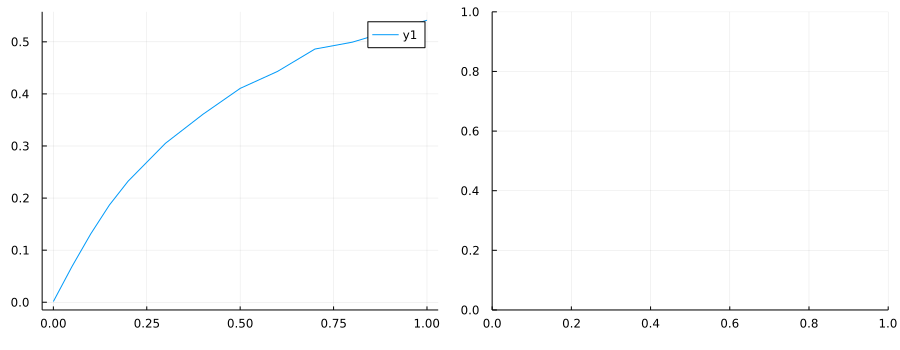

In [121]:
CSV.write("40uK.csv",  Tables.table(cat(scan_list,result_list,dims=2)), writeheader=false);
plot(scan_list,result_list)

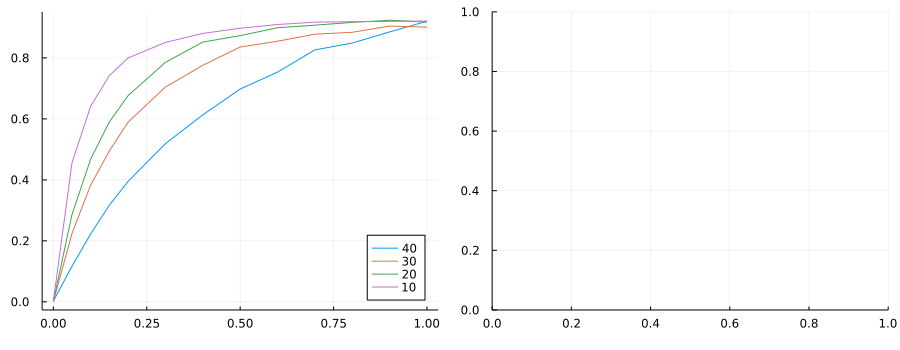

In [152]:
data=Matrix{Float64}(CSV.read("./40uK.csv",header=0,DataFrame))
plot(data[:,1],data[:,2]*1.7,label="40",legend=:bottomright)
data=Matrix{Float64}(CSV.read("./30uK.csv",header=0,DataFrame))
plot!(data[:,1],data[:,2]*1.4,label="30")
data=Matrix{Float64}(CSV.read("./20uK.csv",header=0,DataFrame))
plot!(data[:,1],data[:,2]*1.2,label="20")
data=Matrix{Float64}(CSV.read("./10uK.csv",header=0,DataFrame))
plot!(data[:,1],data[:,2],label="10")

In [ ]:
#TEST: evolve static trap with ramp
steps=500000
dt=1E-7
trajectory_interval=steps/trajectory_length*dt;
@printf("trajectory_interval=%f sec\n",trajectory_interval)
@printf("evolve time=%f sec\n",steps*dt)
CUDA.memory_status()
CUDA.@sync begin
    @cuda threads=cuthreads blocks=cublocks evolve_linear_ramp_snapshot!(cuparticles,N,dt,steps,static_trap,cutrajectory,trajectory_length,1,0.01)
end

In [ ]:
#TEST: show trajectory
copyto!(trajectory,cutrajectory);
particle_index=1
gr(size=(900,350),layout=(1,2),bottom_margin=5Plots.mm)
plot(extract(trajectory[:,particle_index].x,1),subplot=1)
plot!(extract(trajectory[:,particle_index].x,2),subplot=1)
plot!(extract(trajectory[:,particle_index].x,3),subplot=2)

In [ ]:
particle_index=6
gr(size=(900,350),layout=(1,2),bottom_margin=5Plots.mm)
time=LinRange(0,trajectory_interval*size(full_trajectory)[1],size(full_trajectory)[1]);
plot(time,extract(full_trajectory[:,particle_index].x,1),subplot=1)
plot!(time,extract(full_trajectory[:,particle_index].x,2),subplot=1)
plot!(time,extract(full_trajectory[:,particle_index].x,3),subplot=2)

In [ ]:
#stats

abs_x=broadcast(abs,extract(full_trajectory[end,:].x,1))
ind=abs_x.<10E-6;
sum(ind)/N

abs_y=broadcast(abs,extract(full_trajectory[end,:].x,1))
ind=abs_x.<10E-6;
sum(ind)/N
#findall(ind.>0)


In [ ]:
function boltzmann(v,T)
    return (m/(2*pi*kB*T))^(3/2)*4*pi*v^2*exp(-m*v^2/2/kB/T)
end

v=range(0,stop=0.75,length=100)
histogram(map(norm,seed_particles.v),bins=200,normalized=true,subplot=1,label="Particle Histogram",title="random choice")
plot!(v,map(v->boltzmann(v,T*0.7),v),subplot=1,linewidth=5,label="Maxwell-Boltzmann")
histogram!(map(norm,particles.v),bins=200,subplot=2,normalized=true,label="Particle Histogram",title="initial distribution")
plot!(v,map(v->boltzmann(v,T),v),subplot=2,linewidth=5,label="Maxwell-Boltzmann")

In [ ]:
#Check particle histogram on GPU

#Copy from device to host
p=StructArray{Particle,1}(undef,N)
copyto!(p,cuparticles)
#Plot current distribution
gr(size=(900,700),layout=(2,2),bottom_margin=5Plots.mm)
histogram(extract(p.x,1),subplot=1,label="x",xaxis="m")
histogram!(extract(p.x,2),subplot=1,label="y")
histogram!(extract(p.x,3),subplot=3,label="z",xaxis="m")
histogram!(extract(p.v,1),subplot=2,label="vx",xaxis="m/s")
histogram!(extract(p.v,2),subplot=2,label="vy")
histogram!(extract(p.v,3),subplot=4,label="vz",xaxis="m/s")

In [119]:
@time begin
    1+1
end

  0.000000 seconds


2